# Import Dependency #

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import os
import pandas as pd
import random
import PIL as image_lib
import tensorflow as tf
import seaborn as sns
from PIL import Image

from keras.utils import to_categorical 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Read File into List #

In [2]:
#C:\Users\tanca\Desktop\Mini Project\MP Coding\tsrd-train
#C:\Users\tanca\Desktop\Mini Project\MP Coding\TSRD-Train Annotation\TsignRecgTrain4170Annotation.txt

In [3]:
annotation = 'TSRD\TSRD-Train Annotation\TsignRecgTrain4170Annotation.txt'

header = ['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'class']
data = pd.read_csv(annotation, sep=';', header=None, index_col=False, names=header)

data.head()

filename  width  height  x1  y1   x2   y2  class
0  000_0001.png    134     128  19   7  120  117      0
1  000_0002.png    165     151  23  12  149  138      0
2  000_0003.png    128     122  22  14  116  105      0
3  000_0010.png     80      73  14   8   67   63      0
4  000_0011.png    186     174  36  15  155  157      0

In [4]:
print('Number of images: ', len(data))
print('Number of classes: ', len(data['class'].unique()))

Number of images:  4170
Number of classes:  58


Text(0, 0.5, 'Count')

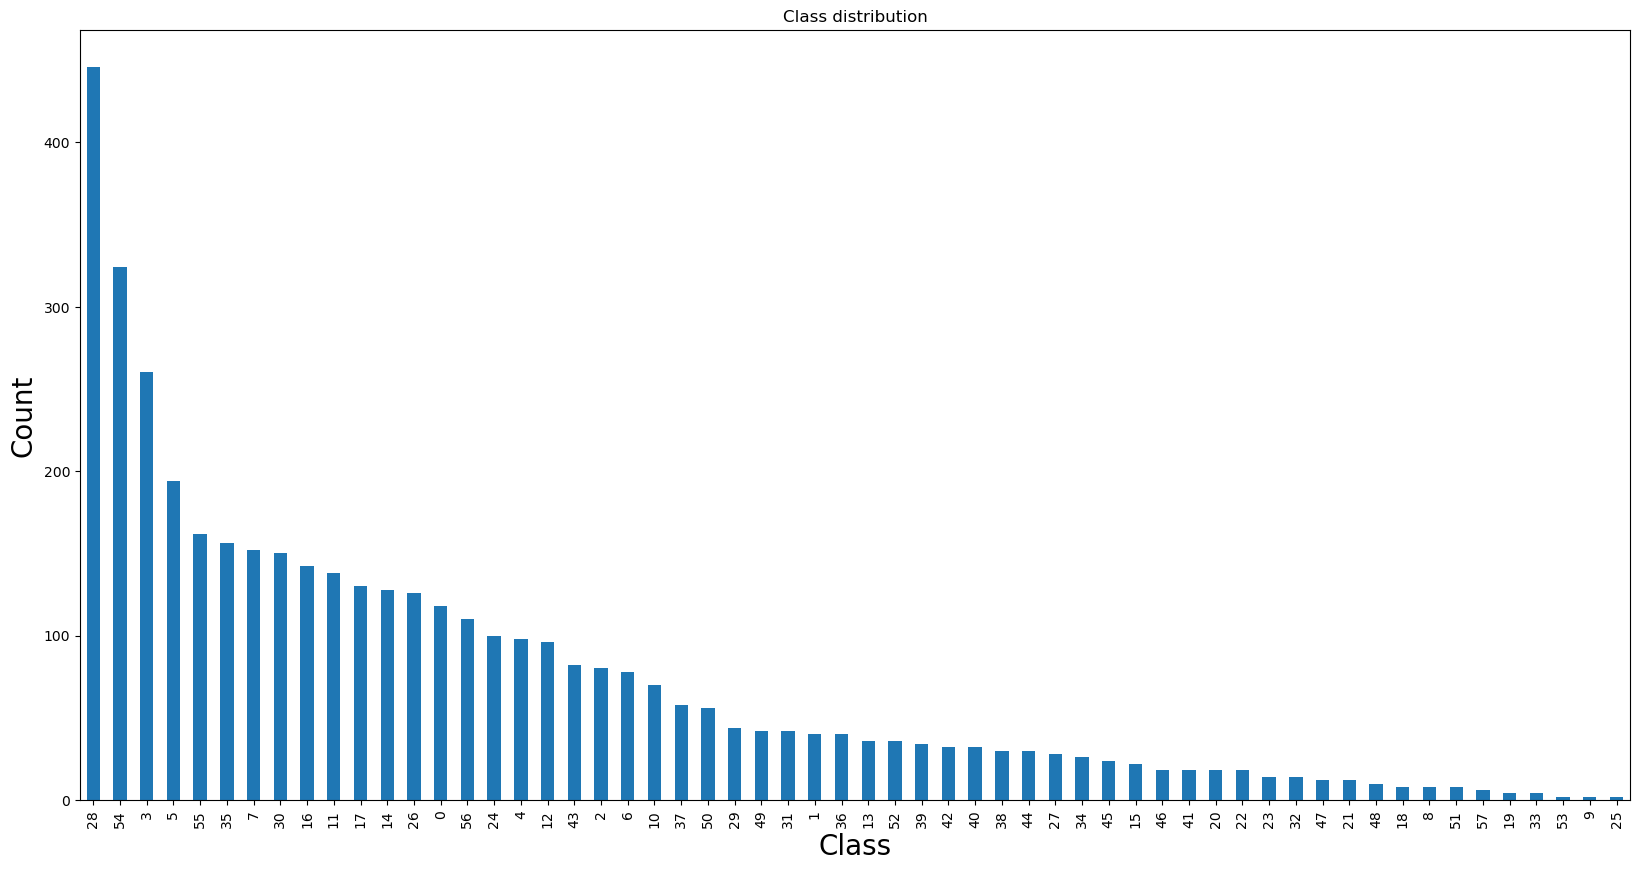

In [5]:
# plot class distribution

data['class'].value_counts().plot(kind='bar', figsize=(20,10))
plt.title('Class distribution')
plt.rcParams.update({'font.size': 20})
plt.xlabel('Class', fontsize=20)
plt.ylabel('Count', fontsize=20)

# Resize image function #

In [6]:
# Function to resize an image with aspect ratio preservation
def resize_image_with_aspect_ratio(image, target_size=(64, 64)):
    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the aspect ratio of the original image
    aspect_ratio = original_width / original_height

    # Calculate new dimensions while maintaining aspect ratio
    target_width, target_height, _ = target_size
    if aspect_ratio > 1:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    # Resize the image using bilinear interpolation to maintain colors
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # Create an empty canvas of the target size
    canvas = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    # Calculate the position to paste the resized image
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2

    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width, :] = resized_image
    
    # Convert the canvas back to BGR color space
    canvas_bgr = cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR)
    
    # Normalize pixel values to the range [0, 1]
    normalized_image = canvas_bgr / 255.0
    
    return normalized_image

In [7]:
imageDim = (64, 64, 3)
count = 0
images = []
classNo = []
noOfClasses = 58
myList = os.listdir('tsrd-train')

print("Importing Classes.....")

for x in range(0, noOfClasses):
    for y in myList:
        if int(y[:3]) == count:
            curImg = cv2.imread(os.path.join('tsrd-train', y))

            # Resize the image while preserving the aspect ratio
            curImg = resize_image_with_aspect_ratio(curImg, target_size=imageDim)

            images.append(curImg)
            classNo.append(count)

    print(count, end=" ")
    count += 1

print(" ")
images = np.array(images)
classNo = np.array(classNo)



Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57  


In [8]:

total_images_per_class = [0] * noOfClasses


# Update the total_images_per_class
for class_idx in classNo:
    total_images_per_class[class_idx] += 1

# Print the number of images per class
for class_idx in range(noOfClasses):
    print(f"Class {class_idx}: {total_images_per_class[class_idx]} images")
overall_total = sum(total_images_per_class)
print(f"Overall Total: {overall_total} images")


Class 0: 118 images
Class 1: 40 images
Class 2: 80 images
Class 3: 260 images
Class 4: 98 images
Class 5: 194 images
Class 6: 78 images
Class 7: 152 images
Class 8: 8 images
Class 9: 2 images
Class 10: 70 images
Class 11: 138 images
Class 12: 96 images
Class 13: 36 images
Class 14: 128 images
Class 15: 22 images
Class 16: 142 images
Class 17: 130 images
Class 18: 8 images
Class 19: 4 images
Class 20: 18 images
Class 21: 12 images
Class 22: 18 images
Class 23: 14 images
Class 24: 100 images
Class 25: 2 images
Class 26: 126 images
Class 27: 28 images
Class 28: 446 images
Class 29: 44 images
Class 30: 150 images
Class 31: 42 images
Class 32: 14 images
Class 33: 4 images
Class 34: 26 images
Class 35: 156 images
Class 36: 40 images
Class 37: 58 images
Class 38: 30 images
Class 39: 34 images
Class 40: 32 images
Class 41: 18 images
Class 42: 32 images
Class 43: 82 images
Class 44: 30 images
Class 45: 24 images
Class 46: 18 images
Class 47: 12 images
Class 48: 10 images
Class 49: 42 images
Cla

# Overview of image #


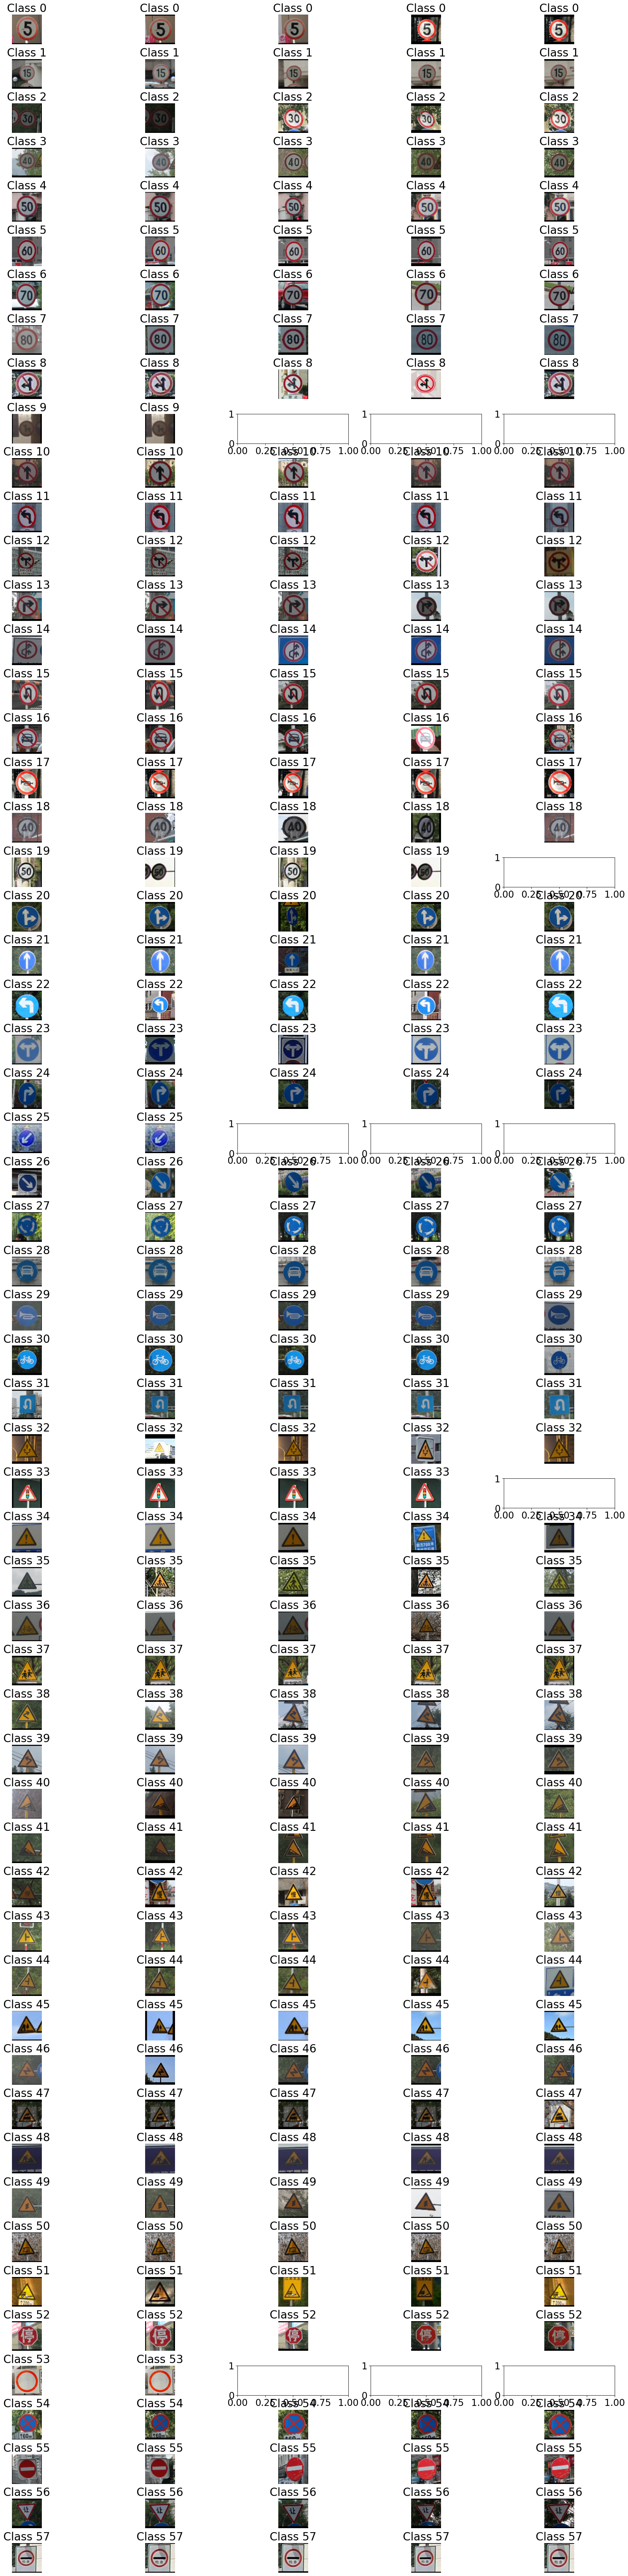

In [9]:
samples_per_class = 5

# Create a figure with a grid layout for displaying images
fig, axs = plt.subplots(noOfClasses, samples_per_class, figsize=(25, 100))  

total_images_per_class = [0] * noOfClasses


for class_idx in range(noOfClasses):
    # Find indices of images in the dataset that belong to this class
    class_indices = np.where(classNo == class_idx)[0]
    
    # Calculate the total number of images for this class
    total_images = len(class_indices)
    
    # Update the counter
    total_images_per_class[class_idx] = total_images
    
    # Select the first 5 samples from this class
    selected_samples = class_indices[:samples_per_class]
    
    # Display the selected samples in a row
    for sample_idx, sample in enumerate(selected_samples):
        axs[class_idx, sample_idx].imshow(images[sample])
        axs[class_idx, sample_idx].set_title(f'Class {class_idx}')
        axs[class_idx, sample_idx].axis('off')

plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing between rows
plt.show()

# Oversampling #

In [10]:
desired_samples_per_class = 446

# Calculate the number of samples needed to reach the desired count for each class
samples_needed_per_class = [desired_samples_per_class - count for count in total_images_per_class]

oversampled_images = []
oversampled_classNo = []


for class_idx in range(noOfClasses):
    if samples_needed_per_class[class_idx] > 0:
        # Find indices of images in the dataset that belong to this class
        class_indices = np.where(classNo == class_idx)[0]
        
        # Calculate the number of images available for this class
        total_images = len(class_indices)
        
        additional_samples_needed = samples_needed_per_class[class_idx]
        
        # Randomly select additional samples from this class with replacement
        selected_samples = np.random.choice(class_indices, additional_samples_needed, replace=True)
        
        oversampled_images.extend(images[selected_samples])
        oversampled_classNo.extend([class_idx] * additional_samples_needed)

oversampled_images = np.array(oversampled_images)
oversampled_classNo = np.array(oversampled_classNo)

for class_idx in range(noOfClasses):
    total_images_per_class[class_idx] += samples_needed_per_class[class_idx]

for class_idx in range(noOfClasses):
    print(f"Class {class_idx}: {total_images_per_class[class_idx]} images")


Class 0: 446 images
Class 1: 446 images
Class 2: 446 images
Class 3: 446 images
Class 4: 446 images
Class 5: 446 images
Class 6: 446 images
Class 7: 446 images
Class 8: 446 images
Class 9: 446 images
Class 10: 446 images
Class 11: 446 images
Class 12: 446 images
Class 13: 446 images
Class 14: 446 images
Class 15: 446 images
Class 16: 446 images
Class 17: 446 images
Class 18: 446 images
Class 19: 446 images
Class 20: 446 images
Class 21: 446 images
Class 22: 446 images
Class 23: 446 images
Class 24: 446 images
Class 25: 446 images
Class 26: 446 images
Class 27: 446 images
Class 28: 446 images
Class 29: 446 images
Class 30: 446 images
Class 31: 446 images
Class 32: 446 images
Class 33: 446 images
Class 34: 446 images
Class 35: 446 images
Class 36: 446 images
Class 37: 446 images
Class 38: 446 images
Class 39: 446 images
Class 40: 446 images
Class 41: 446 images
Class 42: 446 images
Class 43: 446 images
Class 44: 446 images
Class 45: 446 images
Class 46: 446 images
Class 47: 446 images
Cl

# Train Validation Split 

In [11]:
X_combined = np.vstack((images, oversampled_images))
y_combined = np.concatenate((classNo, oversampled_classNo))

X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

In [12]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (20694, 64, 64, 3)
X_val shape: (5174, 64, 64, 3)
y_train shape: (20694,)
y_val shape: (5174,)


# Augmentation

In [13]:

batch_size= 32
# Create data generators for training and validation data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=True)


# Hyperparameter Tuning

In [34]:


# Define a function to create the ResNet-50 model with specified hyperparameters
def create_model(batch_size=32, learning_rate=0.001, optimizer='adam'):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=imageDim))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(noOfClasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create a KerasClassifier with your create_model function
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define hyperparameter grid
param_grid = {
    'batch_size': [32, 64, 128, 256],
    'learning_rate': [0.001, 0.0001, 0.00001],
    'optimizer': ['adam', 'rmsprop']
}

# Create GridSearchCV instance
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)

# Fit the grid search to your data
grid_result = grid.fit(X_train, y_train)


C:\Users\tanca\AppData\Local\Temp\ipykernel_15272\1684030730.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


KeyboardInterrupt: 

In [48]:
best_params = grid_result.best_params_
best_accuracy = grid_result.best_score_

results = grid_result.cv_results_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Mean Accuracy: {mean_score:.4f}, Parameters: {params}")


Best Parameters: {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'adam'}
Best Accuracy: 0.04803324614961942
Mean Accuracy: 0.0480, Parameters: {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'adam'}
Mean Accuracy: 0.0366, Parameters: {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
Mean Accuracy: 0.0175, Parameters: {'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': 'adam'}
Mean Accuracy: 0.0158, Parameters: {'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': 'rmsprop'}
Mean Accuracy: 0.0185, Parameters: {'batch_size': 32, 'learning_rate': 1e-05, 'optimizer': 'adam'}
Mean Accuracy: 0.0149, Parameters: {'batch_size': 32, 'learning_rate': 1e-05, 'optimizer': 'rmsprop'}
Mean Accuracy: 0.0169, Parameters: {'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'adam'}
Mean Accuracy: 0.0159, Parameters: {'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
Mean Accuracy: 0.0180, Parameters: {'batch_size': 64, 'learning_rate': 0.0001,

# Define Model (Resnet 50)

In [28]:
# Define the ResNet-50 model
base_model = ResNet50(include_top=False, input_tensor=Input(shape=imageDim))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(noOfClasses, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 16, 16, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [30]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up training Policy 

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_check = ModelCheckpoint('new_model.h5', 
                              monitor='val_accuracy', 
                              verbose=0, 
                              save_best_only=True, 
                              mode='max')

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0, 
                      patience=5, 
                      verbose=0, 
                      mode='max', 
                      restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0.001)

# Train here !!

In [35]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[model_check, early, reduce_lr] 
)

NameError: name 'train_generator' is not defined

In [14]:
model.save('resnet50_model.h5')

NameError: name 'model' is not defined

In [15]:
from tensorflow.keras.models import load_model

model = load_model('resnet50_model.h5')

# Visualize the Train / Validation accuracy and loss graph

NameError: name 'history' is not defined

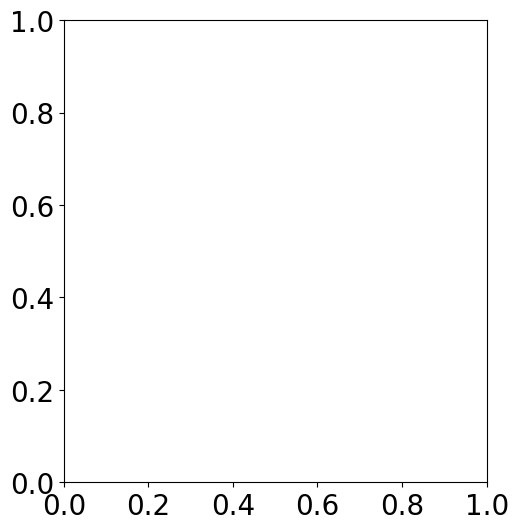

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Test !!

In [17]:
test_annotation = 'NewTest\TSRD-Test Annotation\TsignRecgTest1994Annotation.txt'

test_header = ['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'class']
test_data = pd.read_csv(test_annotation, sep=';', header=None, index_col=False, names=test_header)

x_test = []

# Path to the test image directory
test_image_dir = 'NewTest\TSRD-Test'

print("Segmenting Test Images.....")

for index, row in test_data.iterrows():
    filename = row['filename']

    test_img = cv2.imread(os.path.join(test_image_dir, filename))

    # Apply the aspect ratio preserving resize to the test image
    resized_img = resize_image_with_aspect_ratio(test_img, target_size=imageDim)

    x_test.append(resized_img)

x_test = np.array(x_test)

print("x_test shape:", x_test.shape)

Segmenting Test Images.....
x_test shape: (2006, 64, 64, 3)


## find missing class

In [18]:
unique_train_classes = np.unique(y_train)

# Get the unique class labels in your test dataset
unique_test_classes = np.unique(test_data['class'])

# Find the classes in training data that have no data in the test data
classes_without_test_data = set(unique_train_classes) - set(unique_test_classes)

print("Classes without test data:", classes_without_test_data)


Classes without test data: set()


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('resnet50_model.h5')

y_pred = model.predict(x_test)

predicted_labels = np.argmax(y_pred, axis=1)

y_true_test = test_data['class']

# Calculate accuracy
accuracy = accuracy_score(y_true_test, predicted_labels)
print("Accuracy:", accuracy)

63/63 [==============================] - 14s 182ms/step
Accuracy: 0.7821535393818544


# test accuracy 

In [20]:
from sklearn.metrics import classification_report
import seaborn as sns

# Calculate test accuracy for each class
unique_classes = np.unique(y_true_test)
class_accuracy = {}

for class_label in unique_classes:
    correct_predictions = np.sum((y_true_test == class_label) & (predicted_labels == class_label))
    total_samples = np.sum(y_true_test == class_label)
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    class_accuracy[class_label] = accuracy

# Display test accuracy for each class
for class_label, accuracy in class_accuracy.items():
    print(f"Class {class_label}: Test Accuracy = {accuracy:.2f}")

Class 0: Test Accuracy = 0.86
Class 1: Test Accuracy = 1.00
Class 2: Test Accuracy = 0.97
Class 3: Test Accuracy = 0.90
Class 4: Test Accuracy = 0.62
Class 5: Test Accuracy = 0.68
Class 6: Test Accuracy = 0.87
Class 7: Test Accuracy = 0.76
Class 8: Test Accuracy = 1.00
Class 9: Test Accuracy = 0.00
Class 10: Test Accuracy = 1.00
Class 11: Test Accuracy = 0.74
Class 12: Test Accuracy = 1.00
Class 13: Test Accuracy = 0.74
Class 14: Test Accuracy = 0.33
Class 15: Test Accuracy = 0.44
Class 16: Test Accuracy = 0.97
Class 17: Test Accuracy = 0.74
Class 18: Test Accuracy = 0.00
Class 19: Test Accuracy = 0.67
Class 20: Test Accuracy = 1.00
Class 21: Test Accuracy = 0.67
Class 22: Test Accuracy = 0.50
Class 23: Test Accuracy = 0.60
Class 24: Test Accuracy = 0.92
Class 25: Test Accuracy = 1.00
Class 26: Test Accuracy = 0.88
Class 27: Test Accuracy = 0.67
Class 28: Test Accuracy = 0.91
Class 29: Test Accuracy = 1.00
Class 30: Test Accuracy = 0.82
Class 31: Test Accuracy = 0.78
Class 32: Test Acc

In [21]:
print("\nClassification Report:")
print(classification_report(y_true_test, predicted_labels))


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75        14
           1       0.60      1.00      0.75        12
           2       0.64      0.97      0.77        60
           3       0.93      0.90      0.92        84
           4       0.62      0.62      0.62        58
           5       1.00      0.68      0.81        50
           6       1.00      0.87      0.93        30
           7       1.00      0.76      0.86        50
           8       0.50      1.00      0.67        14
           9       0.00      0.00      0.00         3
          10       0.92      1.00      0.96        60
          11       0.98      0.74      0.84       130
          12       0.65      1.00      0.79        22
          13       0.79      0.74      0.76        92
          14       1.00      0.33      0.50        12
          15       0.89      0.44      0.59        36
          16       1.00      0.97      0.99        76
   

C:\Users\tanca\anaconda3\envs\MP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tanca\anaconda3\envs\MP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tanca\anaconda3\envs\MP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion matrix of each class and Overall class

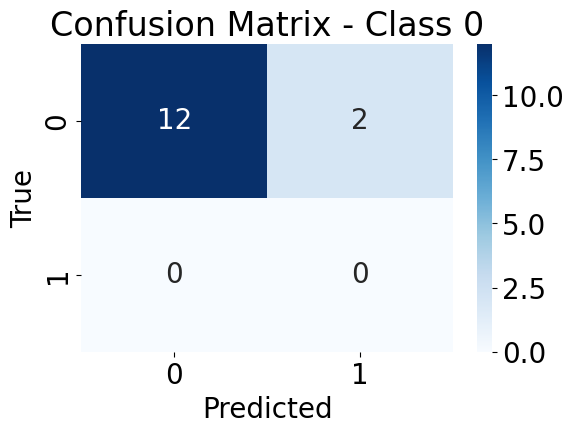

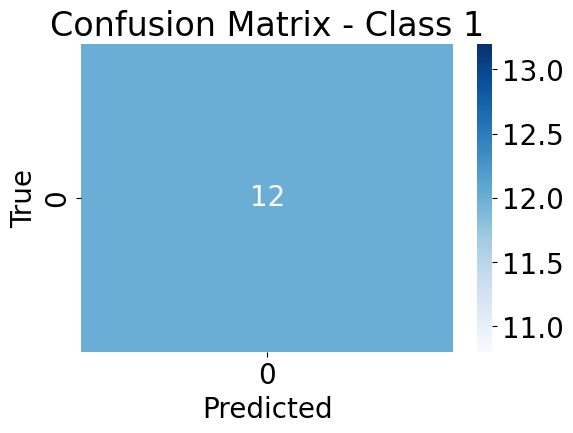

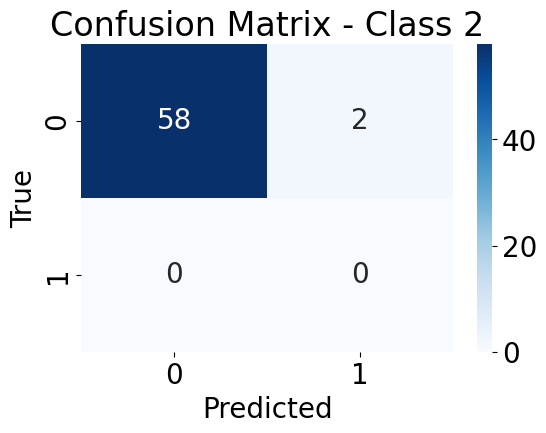

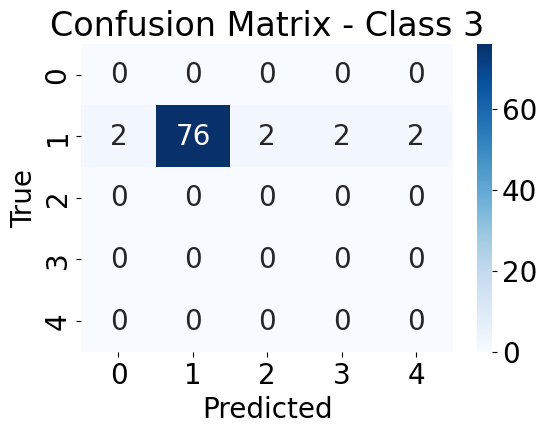

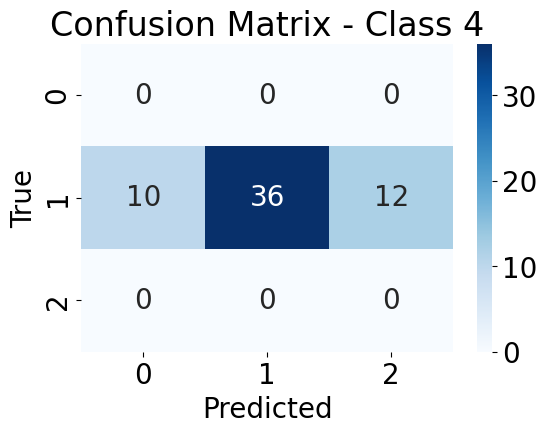

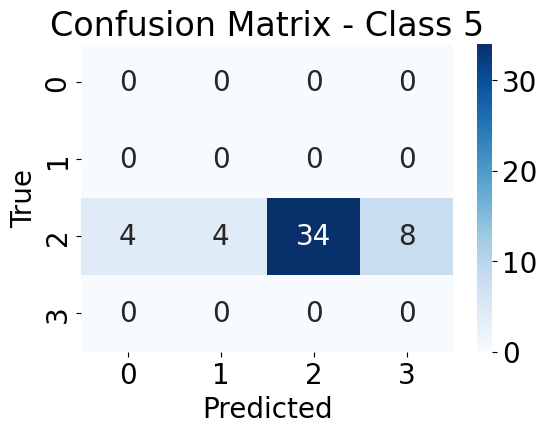

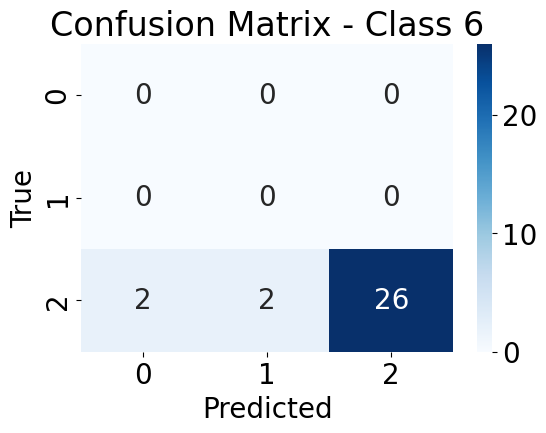

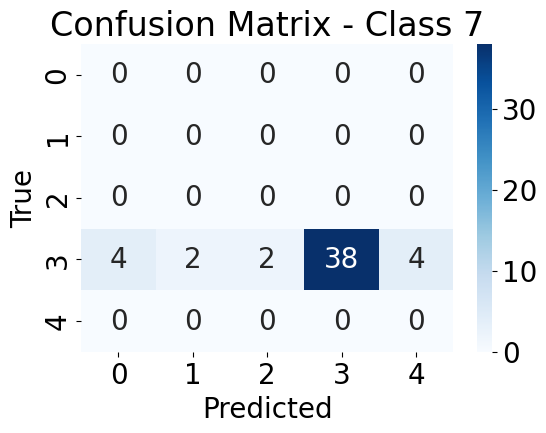

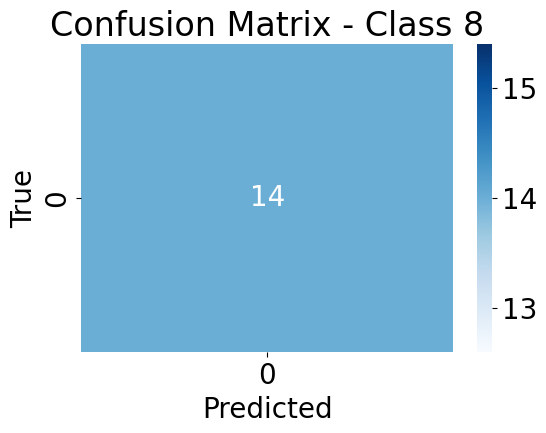

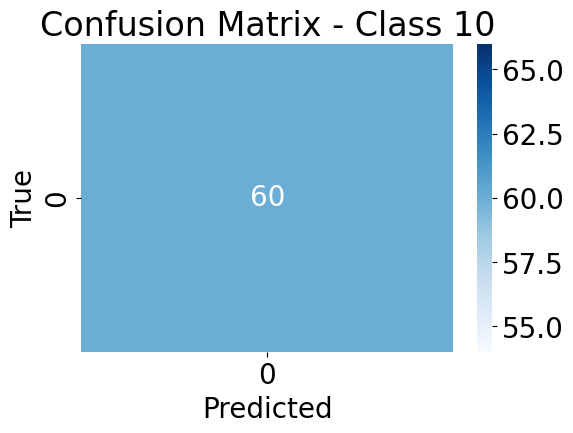

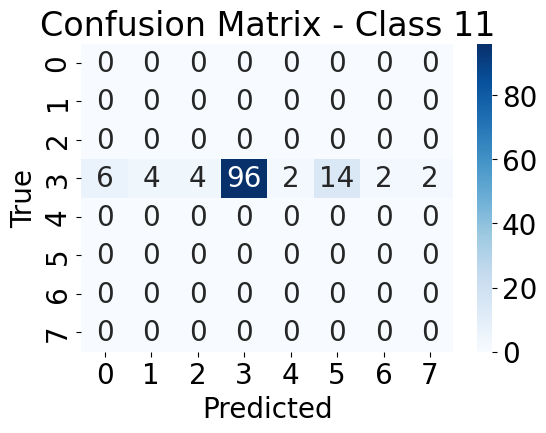

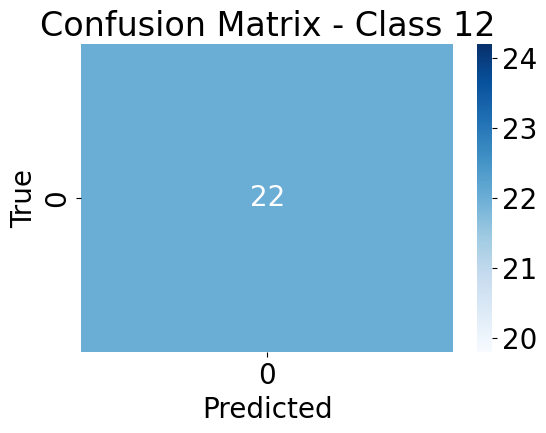

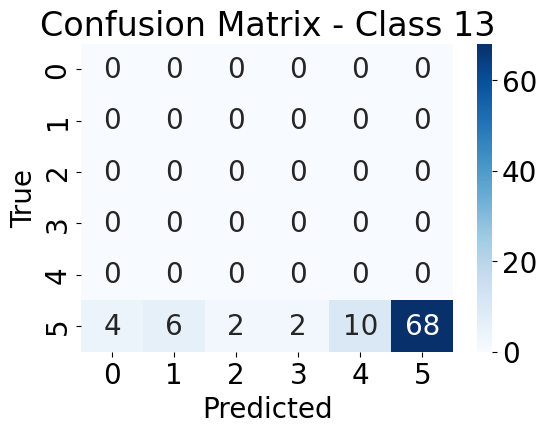

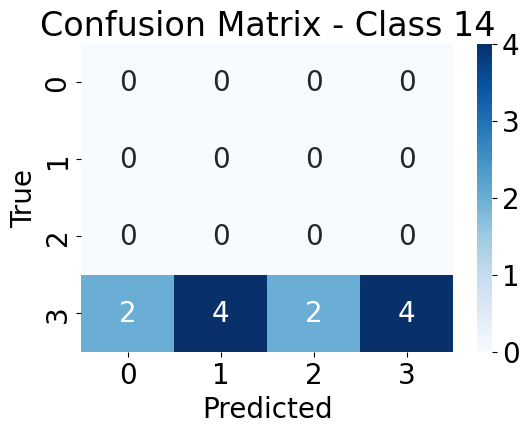

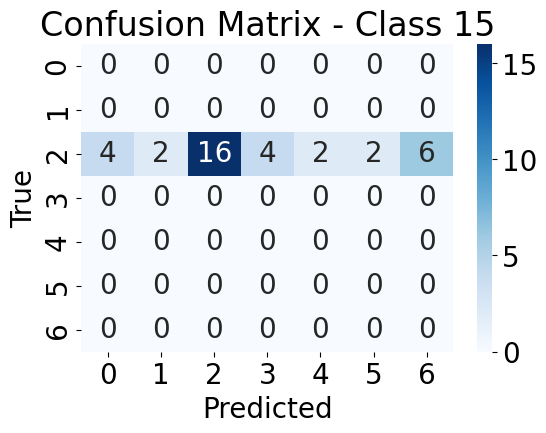

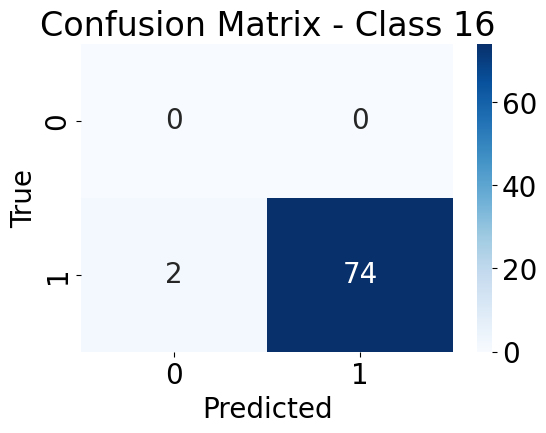

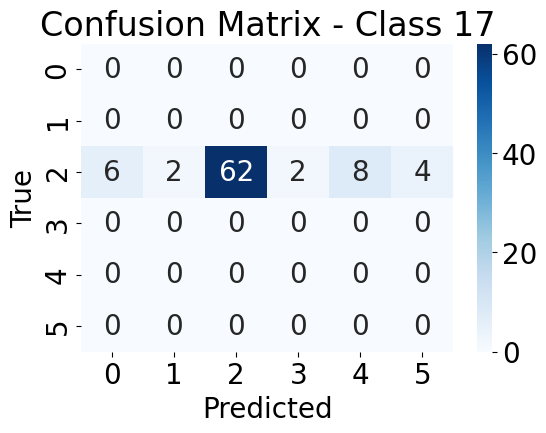

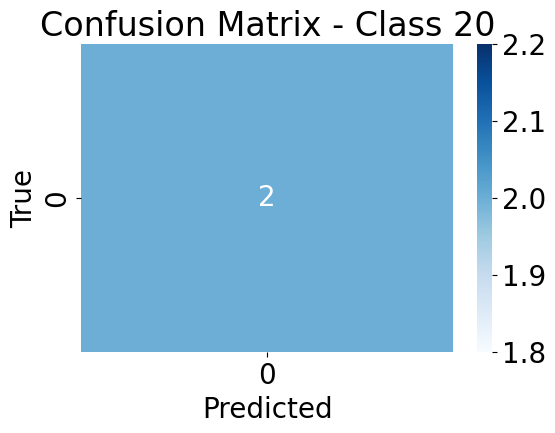

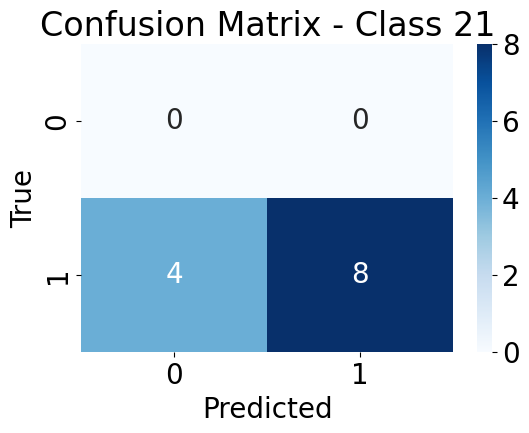

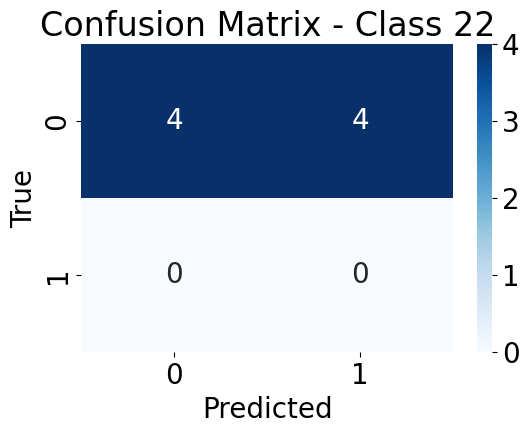

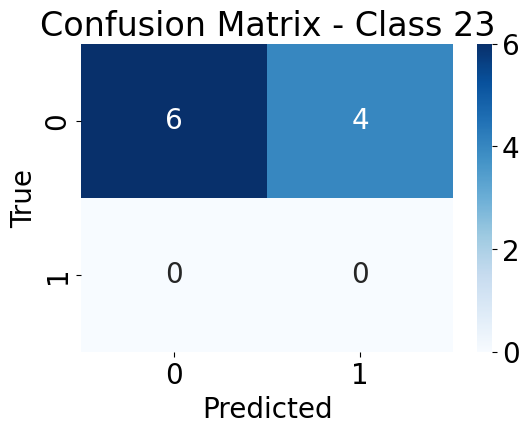

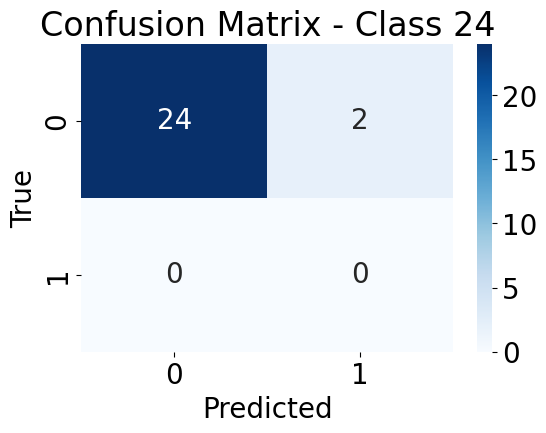

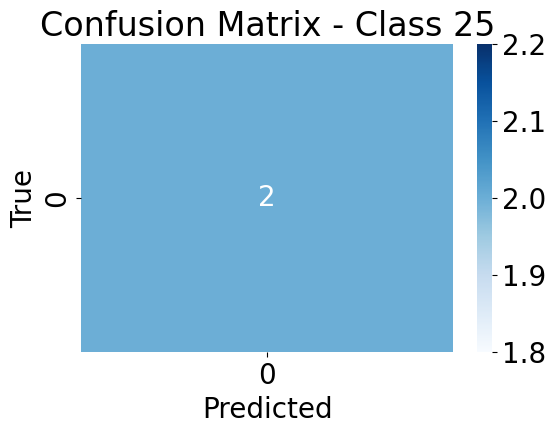

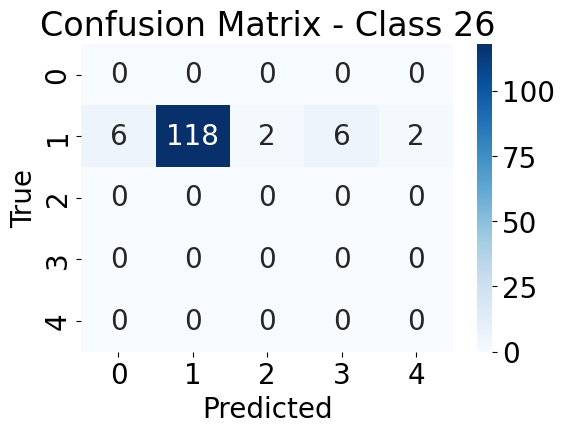

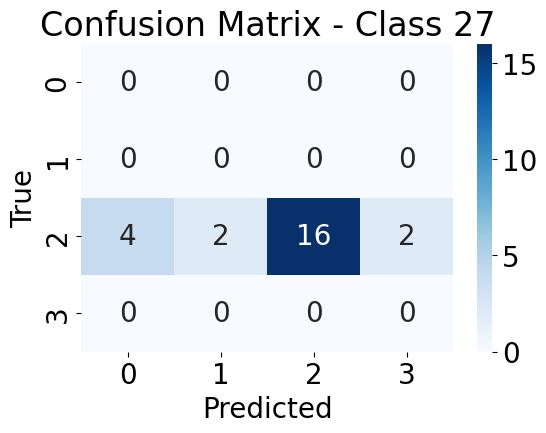

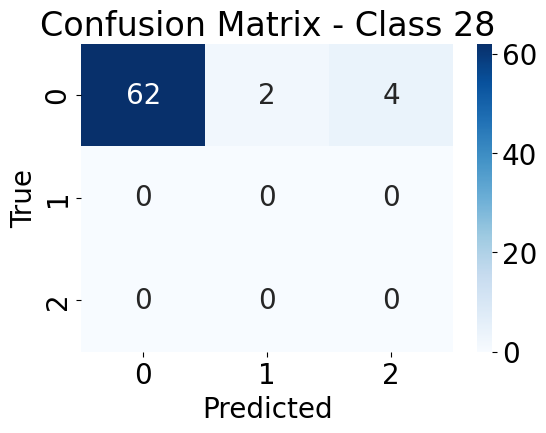

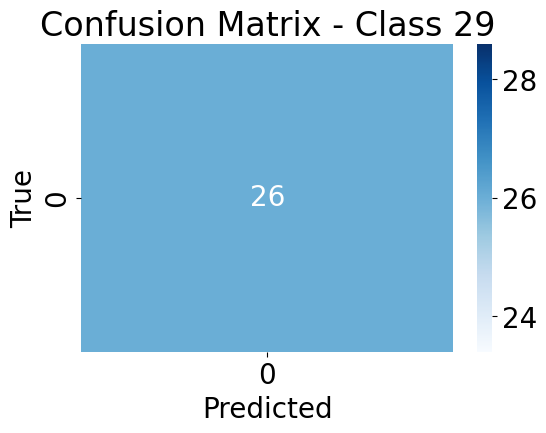

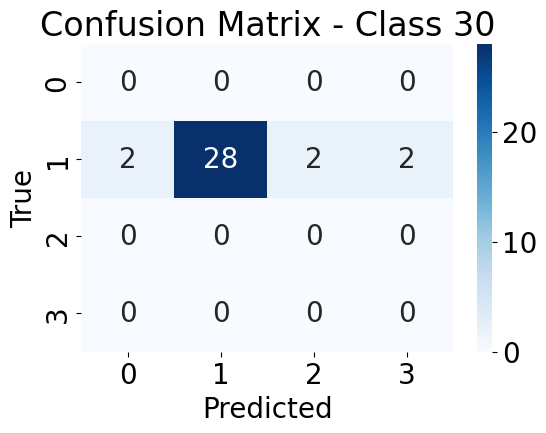

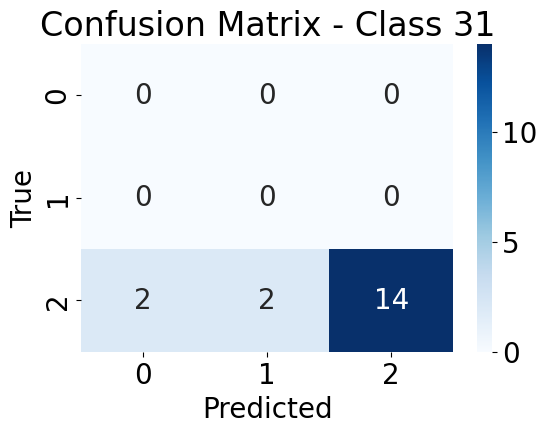

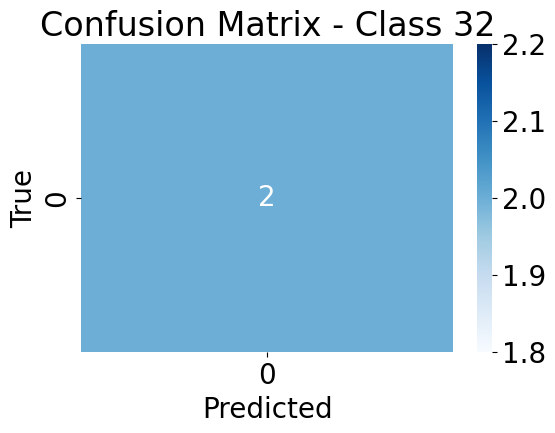

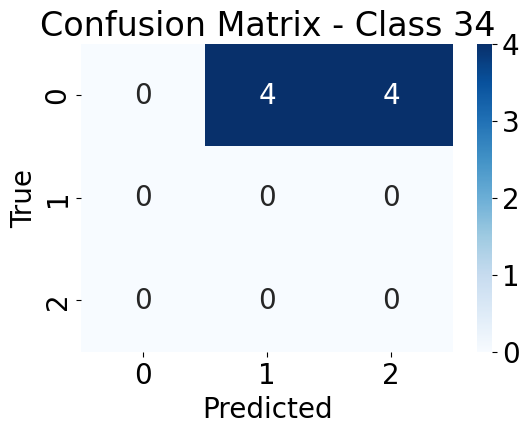

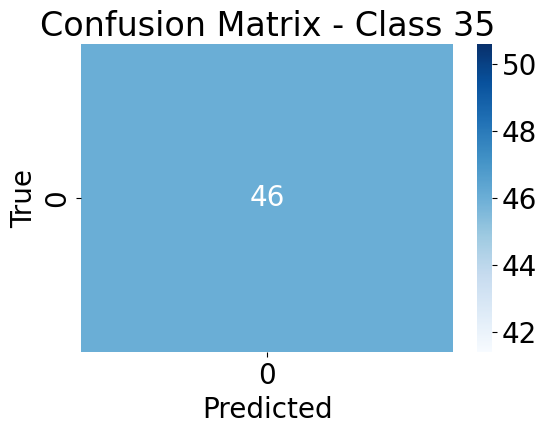

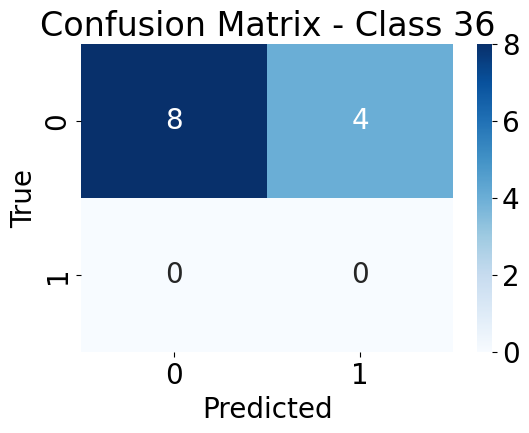

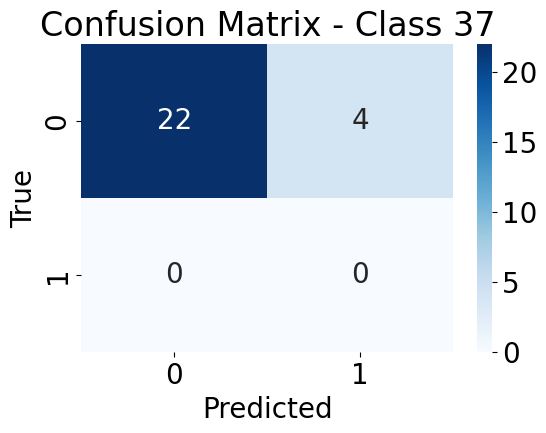

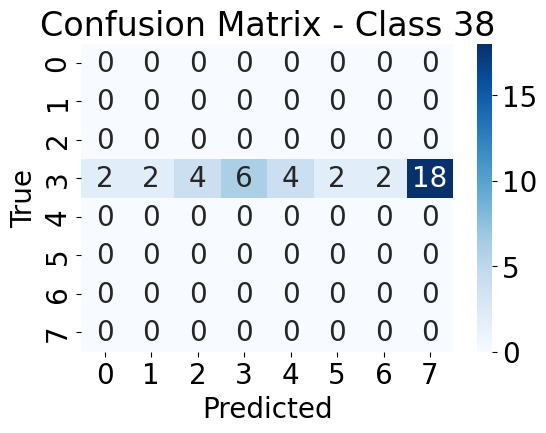

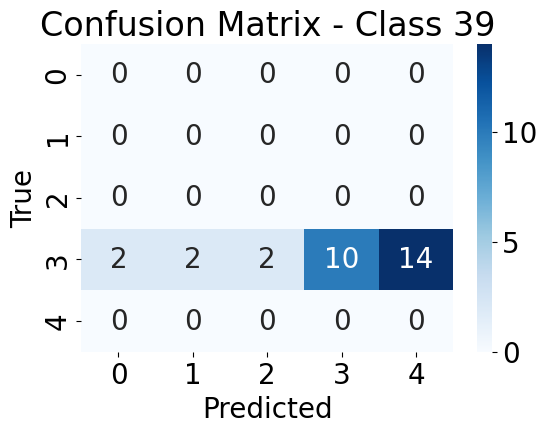

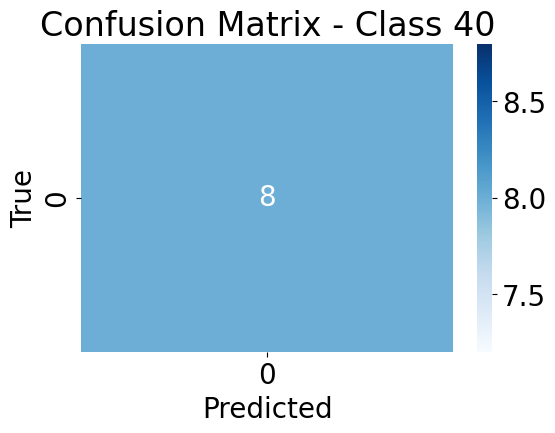

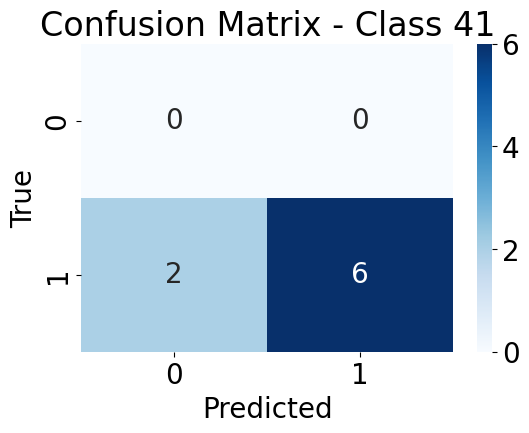

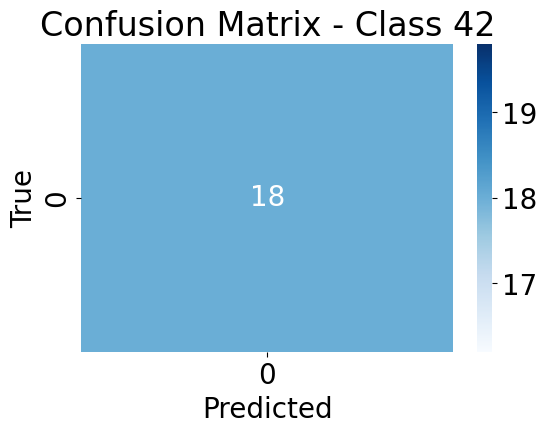

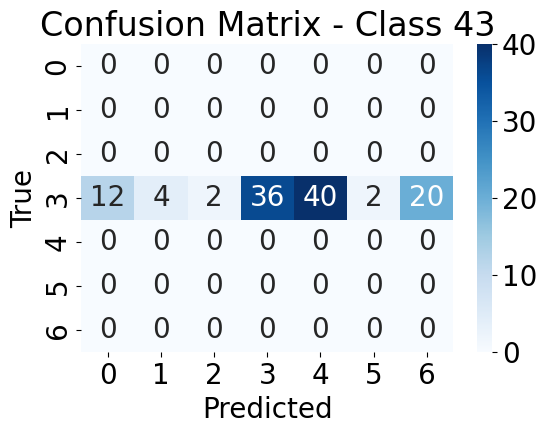

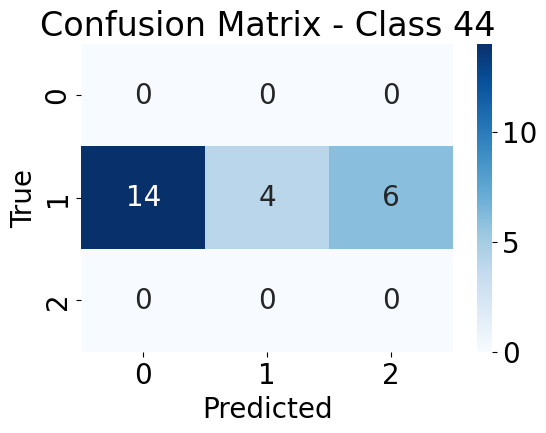

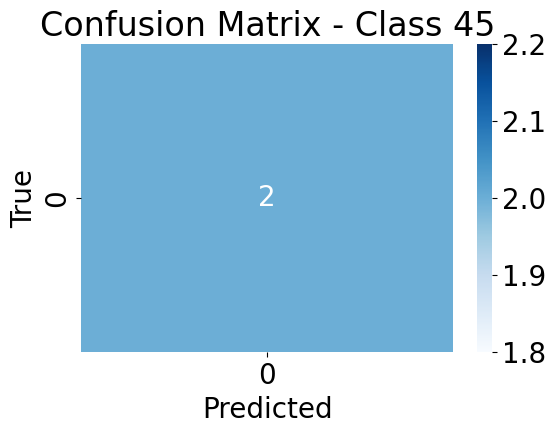

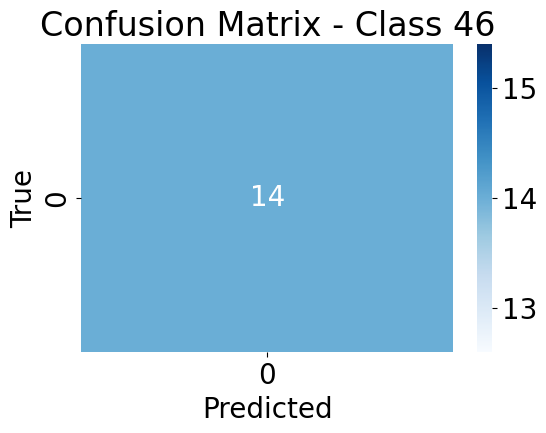

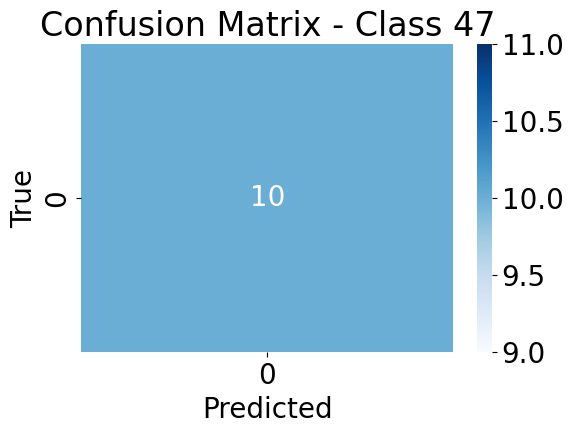

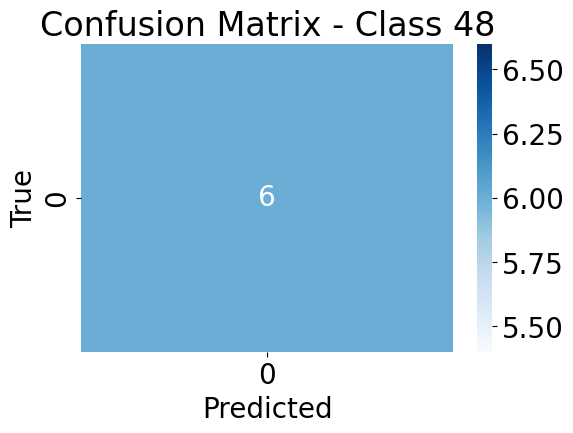

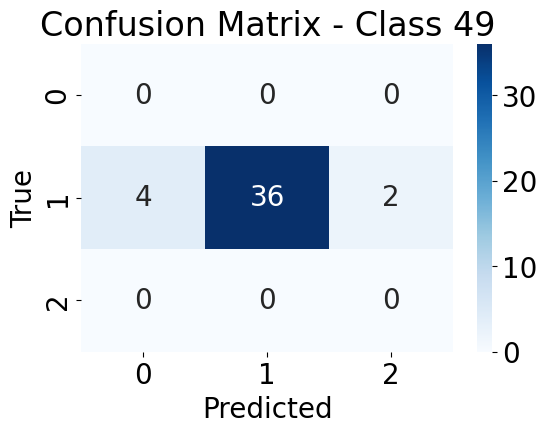

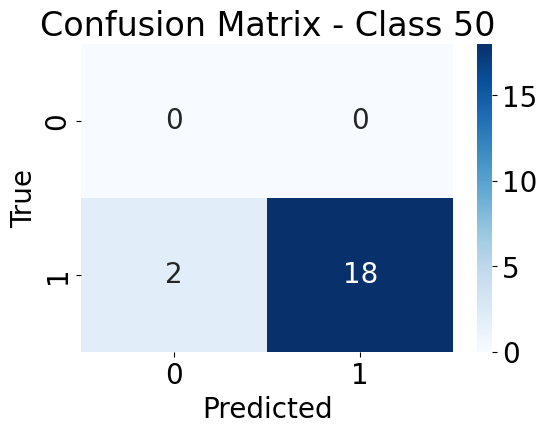

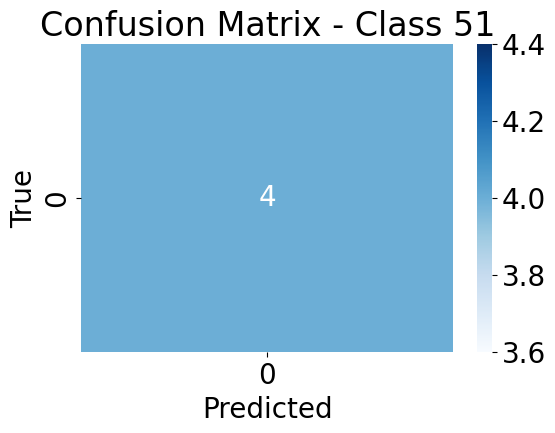

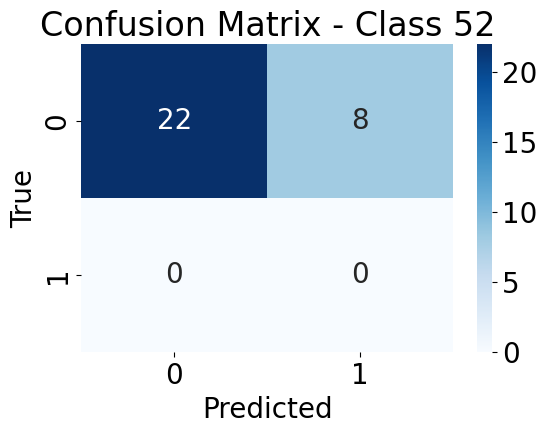

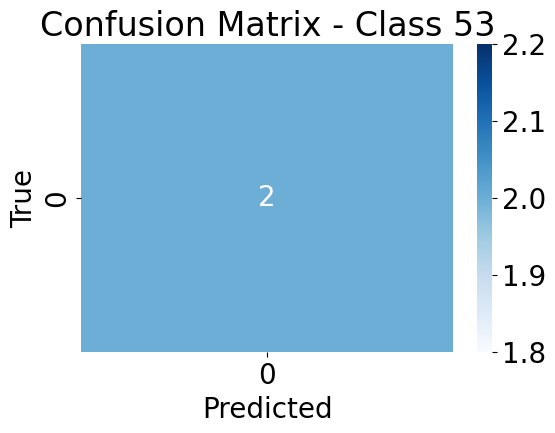

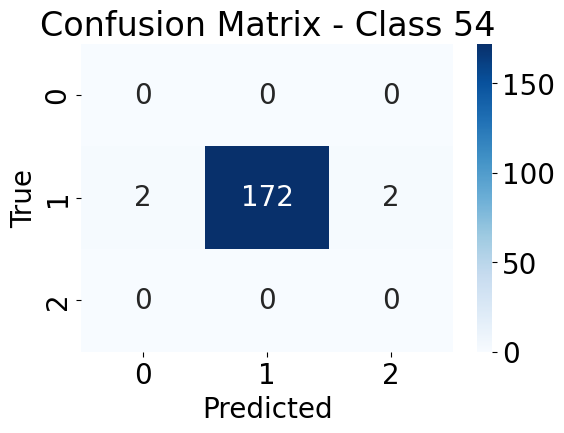

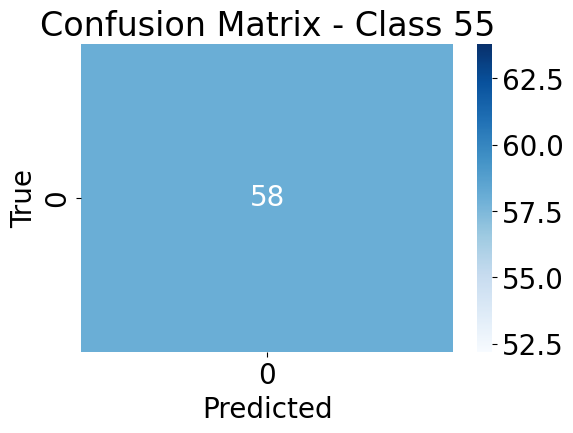

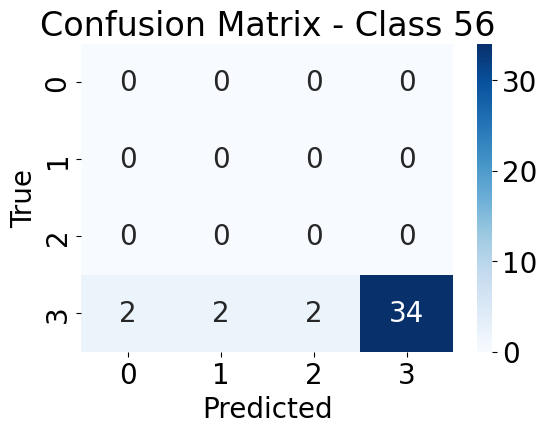

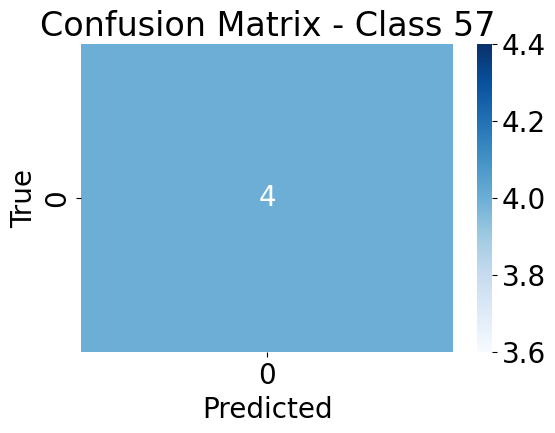

In [37]:
for class_label in unique_classes:
    # Filter the true and predicted labels for the current class
    class_indices = np.where(y_true_test == class_label)[0]  # Convert to 1D array
    class_true_labels = y_true_test.iloc[class_indices].values  # Convert to NumPy array
    class_predicted_labels = predicted_labels[class_indices]
    
    # Calculate the confusion matrix for the current class
    conf_matrix = confusion_matrix(class_true_labels, class_predicted_labels)
    
    # Create a confusion matrix plot for the current class
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True, vmax=np.max(conf_matrix))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Class {class_label}')
    plt.show()

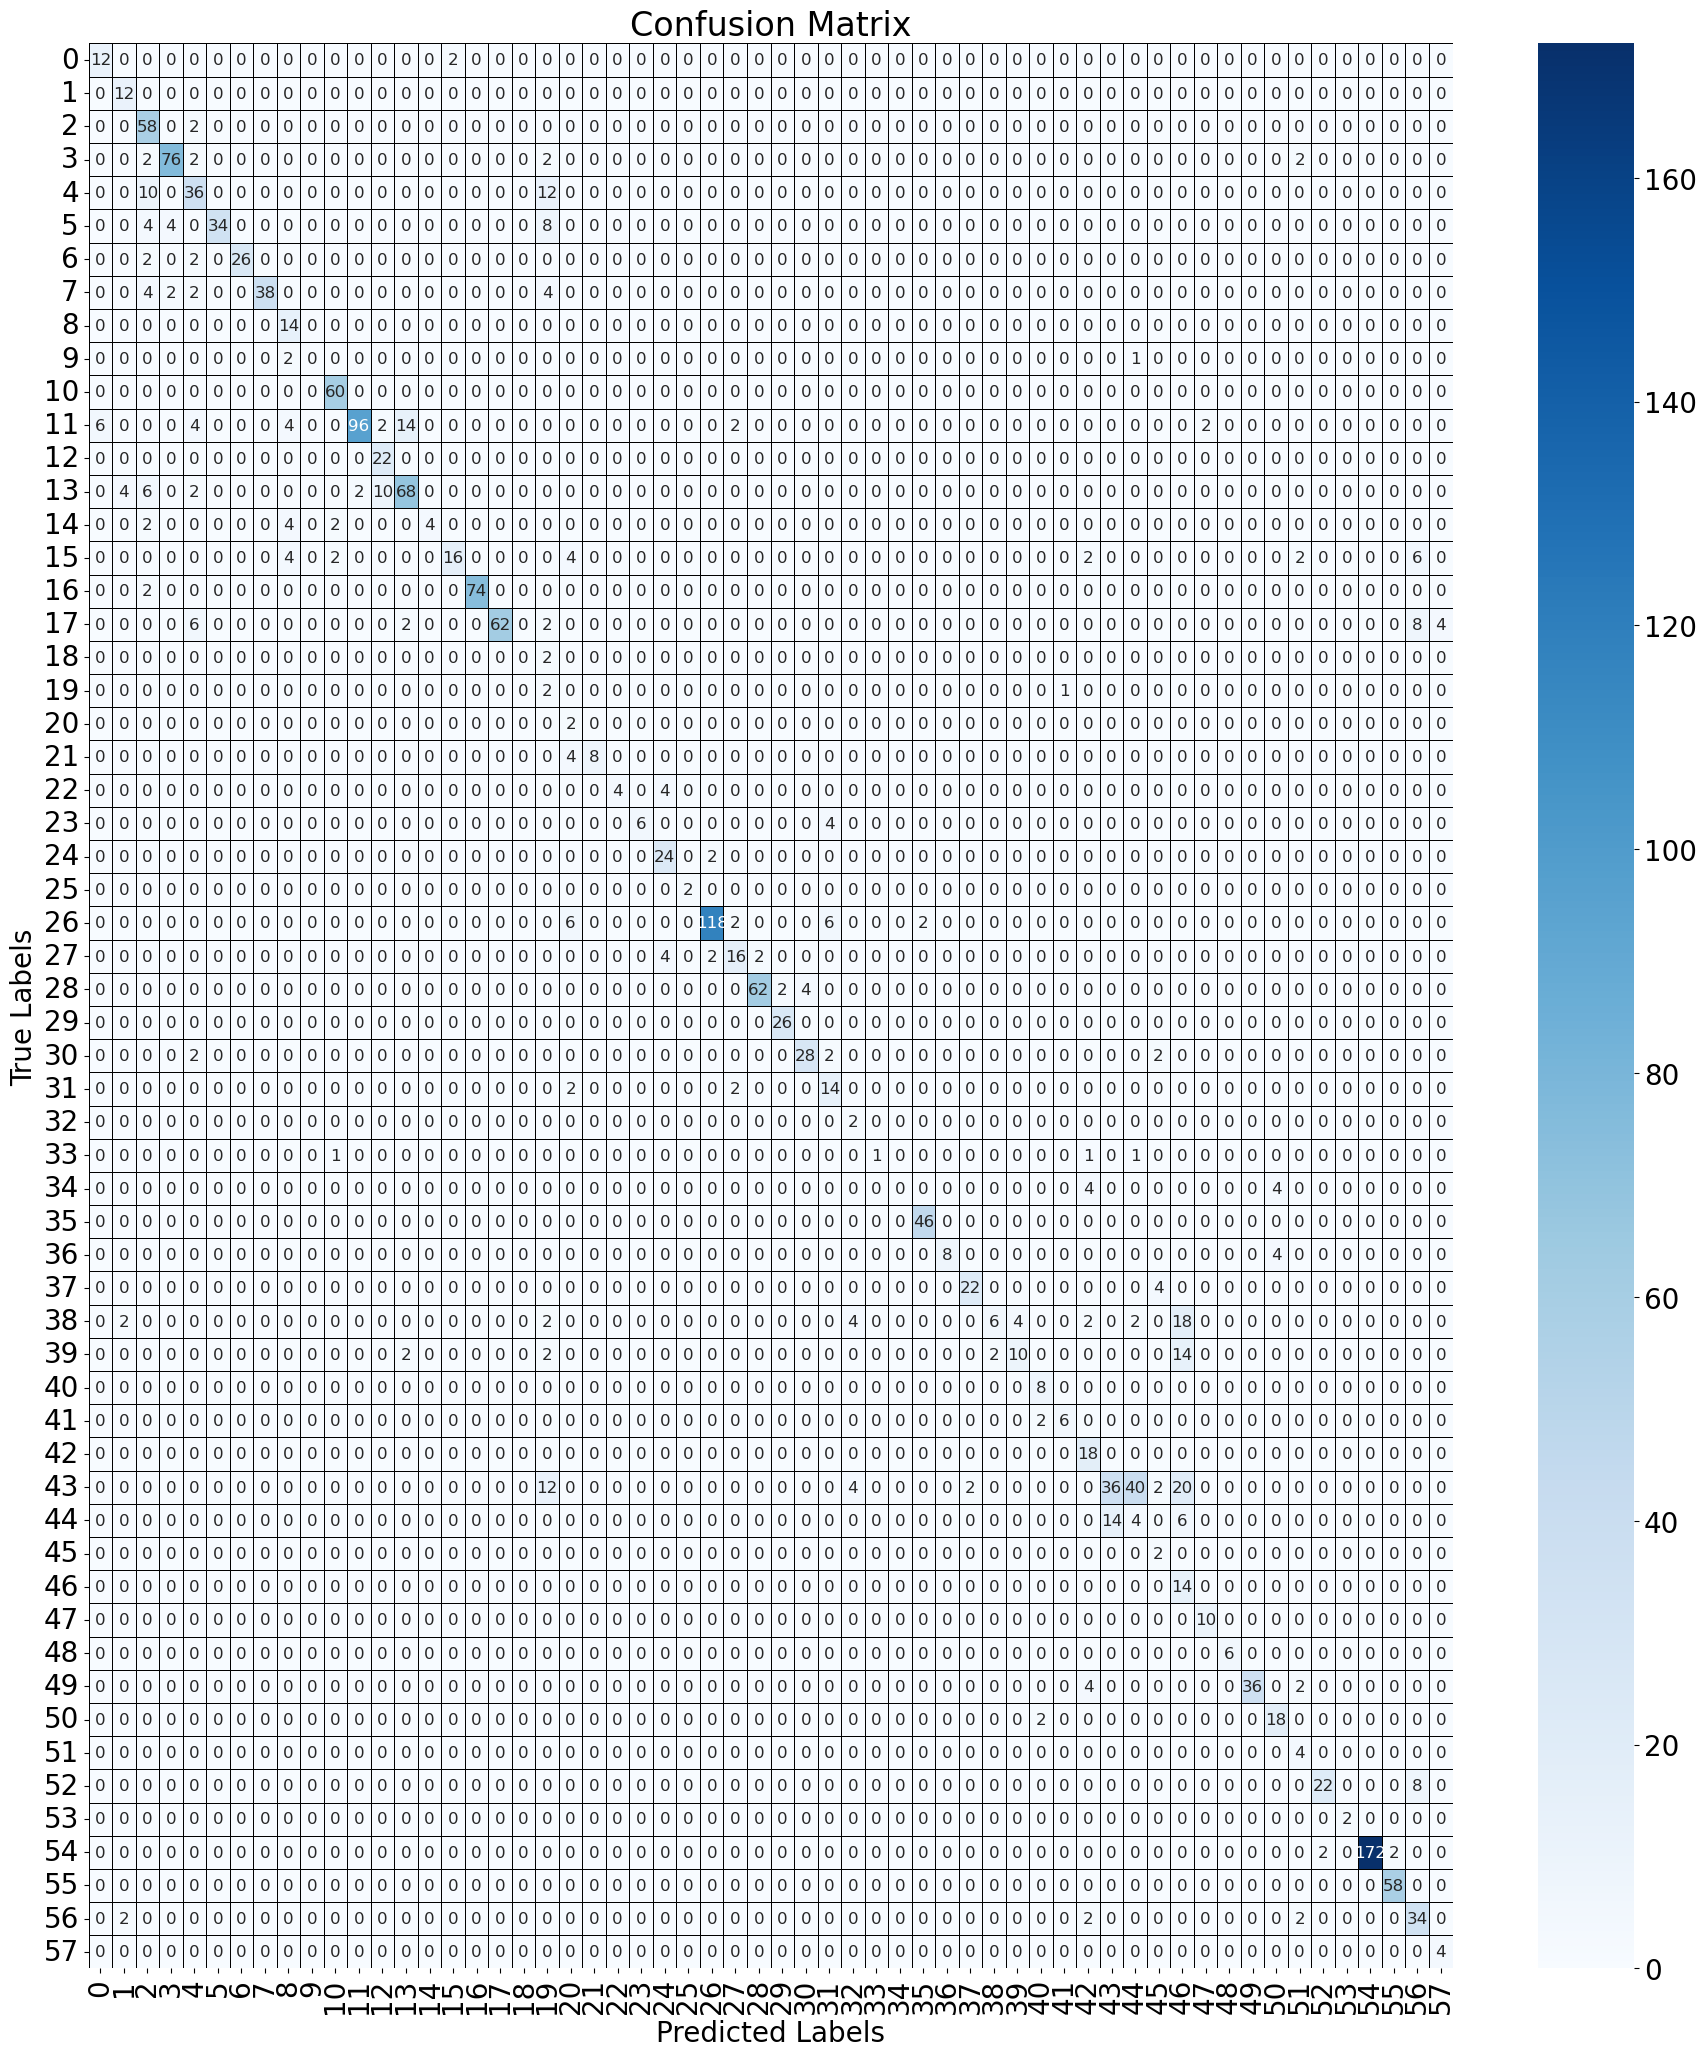

In [27]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_test, predicted_labels)

# Create a larger heatmap for visualization with larger spaces
plt.figure(figsize=(22, 25))

# Adjust the font size of annotations using 'fontsize'
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_classes, yticklabels=unique_classes, linewidths=0.5, linecolor='black', annot_kws={"size": 12})

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
